In [105]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt

parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.insert(0, parent_dir)

from utils import loader, load_data, cpd_accuracy_channel_plot

#### 0. Load forecast_v1, forecast_v2 (new), actual CPD data

In [107]:
## Load data
# List of file paths
file_paths = [
    '../outputs/2024-10-21-20-58-49/cpd_forecast_12_3.csv',
    '../outputs/2024-10-21-20-58-49/cpd_forecast_11_3.csv',
    '../outputs/2024-10-21-20-58-49/cpd_forecast_10_3.csv',
    '../outputs/2024-10-21-20-58-49/cpd_forecast_9_3.csv',
    '../outputs/2024-10-21-20-58-49/cpd_forecast_8_3.csv',
    '../outputs/2024-10-21-20-58-49/cpd_forecast_7_3.csv',
    '../outputs/2024-10-21-20-58-49/cpd_forecast_6_3.csv',
    '../outputs/2024-10-21-20-58-49/cpd_forecast_5_3.csv',
    '../outputs/2024-10-21-20-58-49/cpd_forecast_4_3.csv',
    '../outputs/2024-10-21-20-58-49/cpd_forecast_3_3.csv'
]

# Read and concatenate all CSV files
cpd_forecast_v2 = pd.concat([pd.read_csv(file) for file in file_paths])

# Change dtypes to datetime
cpd_forecast_v2['trip_end_month'] = pd.to_datetime(cpd_forecast_v2['trip_end_month'])

# Sort and rename columns
cpd_forecast_v2.sort_values(['trip_end_month', 'channels'], inplace=True, ignore_index=True)
cpd_forecast_v2.rename({'cost_per_day': 'cpd_forecast_v2', 'trip_end_month': 'forecast_month'}, axis=1, inplace=True)

In [58]:
# v1_forecast_by_channel
rs = loader()
cpd_forecast_v1 = load_data(
    sql_path=os.path.join(parent_dir, 'sql/cpd_old_forecast.sql'),
    loader=rs
)

# Change dtypes to datetime
cpd_forecast_v1['forecast_month'] = pd.to_datetime(cpd_forecast_v1['forecast_month'])
cpd_forecast_v1.rename({'cost_per_trip_day' : 'cpd_forecast_v1'}, axis=1, inplace=True)

In [7]:
# actual data
rs = loader()
cpd_actual = load_data(
    sql_path=os.path.join(parent_dir, 'sql/cpd_actual_channel.sql'),
    loader=rs
)

# Change dtypes to datetime
cpd_actual['signup_month'] = pd.to_datetime(cpd_actual['signup_month'])
cpd_actual.rename({'total_cost_per_day' : 'cpd_actual'}, axis=1, inplace=True)
cpd_actual.sort_values(['signup_month', 'channels', 'increments_from_signup'], inplace=True, ignore_index=True)
cpd_actual['paid_days'] = cpd_actual['paid_days'].astype(float)

# cpd_actual_subset
cpd_actual_subset = cpd_actual.loc[(cpd_actual.signup_month>='2023-09-01') & (cpd_actual.increments_from_signup <= 12)].reset_index(drop=True)

In [57]:
# Create a column for paid_days_weight
cpd_actual_subset['paid_days_weight'] =cpd_actual_subset.groupby(['signup_month', 'channels'])['paid_days'].transform(lambda x: x/x.sum())

# Compute weighted actual cpd values
cpd_actual_subset['w_cpd_actual'] = cpd_actual_subset['cpd_actual']*cpd_actual_subset['paid_days_weight']

weighted_actual_cpd = cpd_actual_subset.groupby(['signup_month', 'channels'], as_index=False).agg({'w_cpd_actual' : 'sum', 'reservations' : 'sum'}) # ['w_cpd_actual'].sum()
weighted_actual_cpd.rename({'signup_month' : 'forecast_month', 'reservations' : 'data_volume_y'}, axis=1, inplace=True)

In [100]:
## Merge all three
cpd_forecasts = pd.merge(cpd_forecast_v2, cpd_forecast_v1, how='left', on=['channels', 'forecast_month'])
cpd_all = pd.merge(cpd_forecasts, weighted_actual_cpd, how='left', on=['channels', 'forecast_month'])
cpd = cpd_all[['forecast_month', 'channels', 'data_volume_y', 'cpd_forecast_v2', 'cpd_forecast_v1', 'w_cpd_actual']].copy()

#### 1. Accuracy

In [104]:
# Channels included for payback period calculation
payback_channels = ['Apple','Google_Desktop','Google_Desktop_Brand','Google_Discovery',
    'Google_Mobile','Google_Mobile_Brand','Google_UAC_Android','Kayak_Desktop',
    'Kayak_Desktop_Core', 'Kayak_Mobile_Core','Mediaalpha','Expedia','Microsoft_Desktop',
    'Microsoft_Desktop_Brand','Microsoft_Mobile', 'Microsoft_Mobile_Brand','Kayak_Desktop_Front_Door',
    'Kayak_Desktop_Compare','Google_Pmax','Kayak_Desktop_Carousel','Kayak_Mobile_Carousel',
    'Kayak_Mobile','Kayak_Afterclick', 'Facebook/IG_App', 'Facebook/IG_Web']

# Keep only payback channels
cpd_payback = cpd.loc[cpd.channels.isin(payback_channels)].reset_index(drop=True)

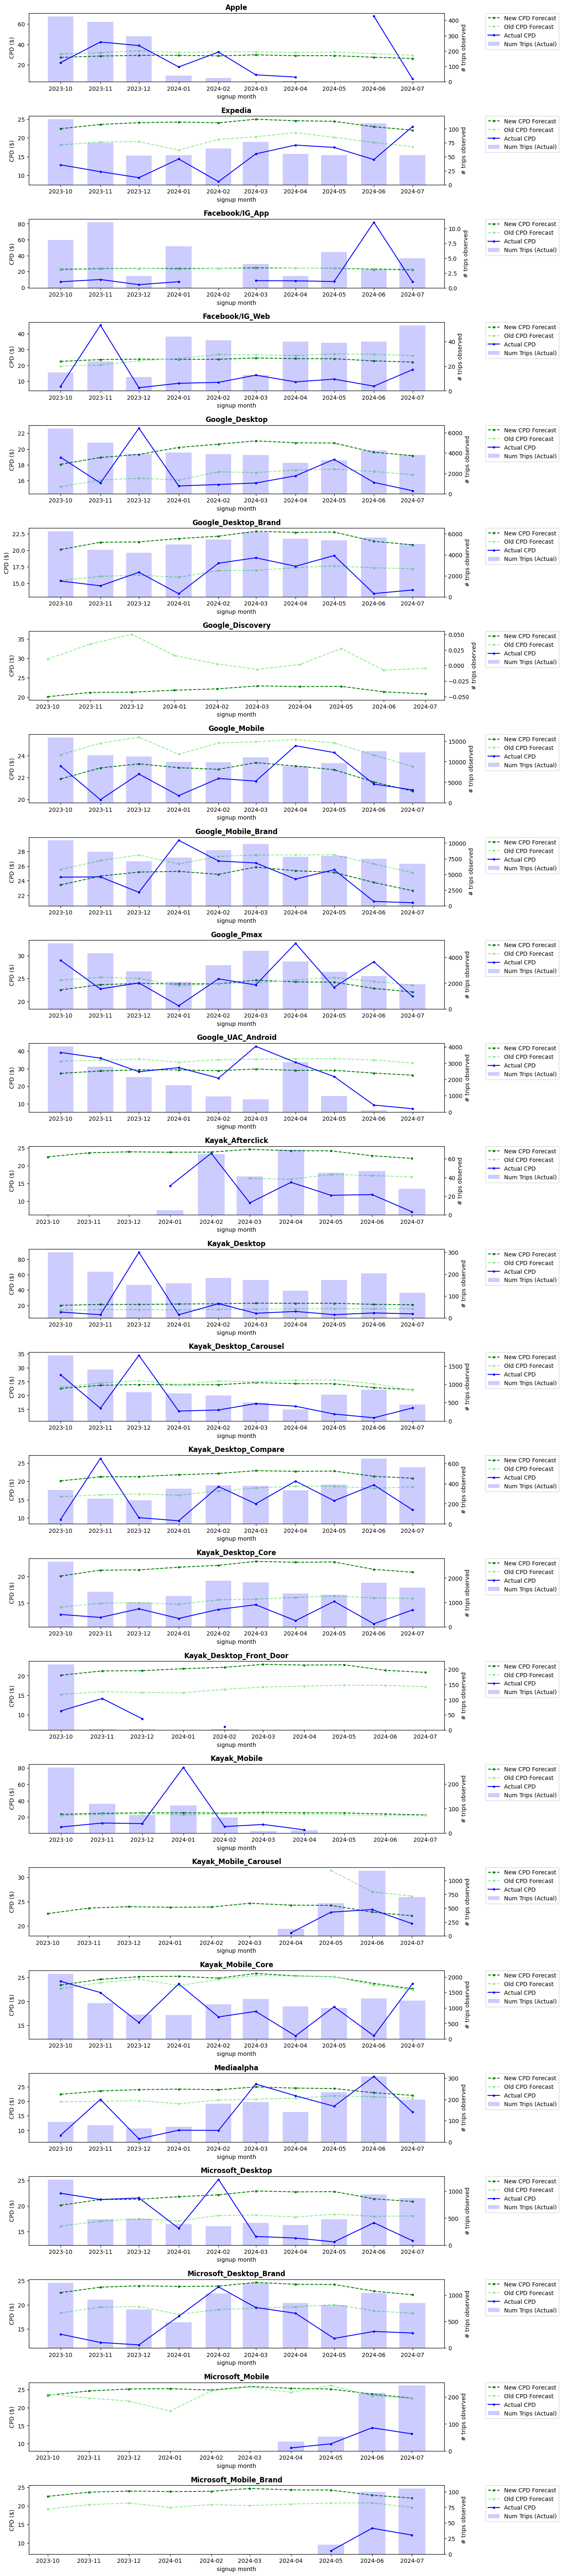

In [106]:
cpd_accuracy_channel_plot(cpd_payback)